## Spark Machine Learning

Bike sharing is a service provided now by several major cities around the world. Data is regularly and automatically collected on this services by the renting system. Analyzing it can help predict usage levels and effectively provide a ‘map‘ of the city traffic activity and hot spots. The dataset corresponds to  **Washington DC**.

### Objective:

Build a predictive model capable of predicting the total number of bike rentals per hour for a given weekday.

### Workflow:
1. Load Data
2. Inspect Data
3. Preprocess Data
4. Create Model
5. Make Predictions
6. Evaluate how good are your predictions

In [59]:
# Initial settings
import os
my_home=os.environ['HOME']
trip_dataset_path="/home/vagrant/spark-course/challenge_3/Bike_data/" # path to trip csv
weather_dataset_path="/home/vagrant/spark-course/challenge_3/" # path to weather csv
outputs_path=my_home

In [60]:
print(os.environ['SPARK_HOME'])

/usr/local/software/spark


In [61]:
# Importing pyspark
import pyspark

In [62]:
# Create a SparkSession and specify configuration
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("SparkML") \
    .getOrCreate()

In [63]:
# Checking spark version
spark.version

'2.2.0'

### Load Data

In [64]:
# use SparkSession and infer schema with header (messy header names so we change them for predefined ones)
# import all trip data csv
df_trip = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("file:///"+trip_dataset_path+"*.csv")

In [65]:
# use SparkSession and infer schema with header (messy header names so we change them for predefined ones)
# import all weather data csv
df_weather = spark.read \
            .option("header", "false") \
            .option("inferSchema", "true") \
            .csv("file:///"+weather_dataset_path+"weather_data_daily.csv")

In [66]:
# Check the trip schema 
df_trip.printSchema()

root
 |-- Duration (ms): integer (nullable = true)
 |-- Start date: timestamp (nullable = true)
 |-- End date: timestamp (nullable = true)
 |-- Start station number: string (nullable = true)
 |-- Start station: string (nullable = true)
 |-- End station number: string (nullable = true)
 |-- End station: string (nullable = true)
 |-- Bike number: string (nullable = true)
 |-- Member type: string (nullable = true)



In [67]:
# Check the weather schema
df_weather.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: integer (nullable = true)
 |-- _c4: integer (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)



The column names in df_trip contain blank spaces, so we rename the columns to get rid of that:

In [68]:
# New column names
trip_names = ['duration_ms', 
              'start_date', 
              'end_date',
              'start_station_nr', 
              'start_station',
              'end_station_nr', 
              'end_station', 
              'bike_nr', 
              'member_type'] 

# Old column names
rownames = df_trip.schema.names

# Define function for chaning column names
def updateColNames(df, oldnames, newnames):
    for i in range(len(newnames)):
        df=df.withColumnRenamed(oldnames[i], newnames[i])
    return df

# Run function and redefine df
df_trip=updateColNames(df_trip, rownames, trip_names)

# Checking again the schema
df_trip.printSchema()

root
 |-- duration_ms: integer (nullable = true)
 |-- start_date: timestamp (nullable = true)
 |-- end_date: timestamp (nullable = true)
 |-- start_station_nr: string (nullable = true)
 |-- start_station: string (nullable = true)
 |-- end_station_nr: string (nullable = true)
 |-- end_station: string (nullable = true)
 |-- bike_nr: string (nullable = true)
 |-- member_type: string (nullable = true)



We assign column names to the weather dataframe

In [69]:
weather_names = ['location', 
                 'date', 
                 'source', 
                 'max_temp', 
                 'avg_temp', 
                 'HDDs', 
                 'CDDs', 
                 'precipitation', 
                 'snowfall', 
                 'snow_depth']

# Old column names
rownames1 = df_weather.schema.names

# Run function and redefine df
df_weather=updateColNames(df_weather, rownames1, weather_names)

# Checking again the schema
df_weather.printSchema()

root
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- source: string (nullable = true)
 |-- max_temp: integer (nullable = true)
 |-- avg_temp: integer (nullable = true)
 |-- HDDs: double (nullable = true)
 |-- CDDs: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snowfall: double (nullable = true)
 |-- snow_depth: double (nullable = true)
 |-- _c10: double (nullable = true)



In the data description only 10 columns for the weather dataset are defined. For now let's keep the additional column, later during data exploration we will decide what to do with it.

### Data Exploration

In [70]:
# Caching the df
df_trip.cache()
df_weather.cache()

DataFrame[location: string, date: string, source: string, max_temp: int, avg_temp: int, HDDs: double, CDDs: double, precipitation: double, snowfall: double, snow_depth: double, _c10: double]

In [71]:
# Create a temp table for SQL access
df_trip.registerTempTable('train_data')
df_weather.registerTempTable('weather_data')

In [72]:
# Summary statistic on some selected variables for trip_df
df_trip.select('duration_ms', 
               'start_station', 
               'end_station', 
               'bike_nr', 
               'member_type') \
               .describe() \
               .show()

+-------+------------------+--------------------+--------------------+--------------------+-----------+
|summary|       duration_ms|       start_station|         end_station|             bike_nr|member_type|
+-------+------------------+--------------------+--------------------+--------------------+-----------+
|  count|          19120900|            19120900|            19120900|            19120900|   19120900|
|   mean|1094822.9341764771|                null|                null|                null|       null|
| stddev|2070744.2093020782|                null|                null|                null|       null|
|    min|             60001|      10th & E St NW|      10th & E St NW|?(0x0000000008D29...|     Casual|
|    max|          86394082|Yuma St & Tenley ...|Yuma St & Tenley ...|              w01117|    Unknown|
+-------+------------------+--------------------+--------------------+--------------------+-----------+



In [73]:
# Summary statistic on some selected variables for weather_df
df_weather.select('max_temp', 
                  'avg_temp', 
                  'precipitation') \
                  .describe() \
                  .show()

+-------+------------------+-----------------+------------------+
|summary|          max_temp|         avg_temp|     precipitation|
+-------+------------------+-----------------+------------------+
|  count|              2922|             2922|              2922|
|   mean| 66.61738535249829| 46.0321697467488|3.6534907597535935|
| stddev|18.499389192282433|17.34384505608877|5.7078361780764615|
|    min|                15|               -4|               0.0|
|    max|               105|               78|              25.5|
+-------+------------------+-----------------+------------------+



In [74]:
# Summary statistic on some selected variables for weather_df
df_weather.select('snowfall', 
                  'snow_depth',
                  '_c10') \
                  .describe() \
                  .show()

+-------+-------------------+------------------+------------------+
|summary|           snowfall|        snow_depth|              _c10|
+-------+-------------------+------------------+------------------+
|  count|               2922|              2920|              2884|
|   mean|0.11165999315537209|0.0742592465753426|0.2584500693481275|
| stddev|0.32765845448894304|0.7899262945288358|1.8191148674777877|
|    min|                0.0|               0.0|               0.0|
|    max|               4.74|              22.1|              28.0|
+-------+-------------------+------------------+------------------+



### Data Preprocessing

The goal of this analysis is to predict the total number of bikes rented per hour on any given day. To reach this goal, we need to transform trip_df into a format that accomodates our goal better.
In particular we need to extract the day and hour columns from the original date column. In addition, for our initial analysis, we won't need any other columns from df_trip (e.g. start station, duration, ecc..).

In [75]:
from pyspark.sql import functions as F

#### Creating new columns

In [76]:
# Let's create the new columns year, month, day and hour that we need for df_trip
df_trip = df_trip.withColumn('t_year', F.year('start_date')) # year column
df_trip = df_trip.withColumn('t_month', F.month('start_date')) # month column
df_trip = df_trip.withColumn('t_day', F.dayofmonth('start_date')) # day column
df_trip = df_trip.withColumn('hour', F.hour('start_date')) # hour column
df_trip = df_trip.withColumn('weekday', F.date_format('start_date', 'E').alias('dow_string')) # weekday column

In [77]:
# Let's create the new columns year, month, day and hour that we need for df_weather as well

# converting string to timestamp
format = "MM/dd/yyy HH:mm:ss"
df_weather = df_weather.withColumn('Timestamp', F.unix_timestamp('date', format).cast('timestamp'))

# creating the new columns
df_weather = df_weather.withColumn('w_year', F.year('timestamp')) # year column
df_weather = df_weather.withColumn('w_month', F.month('timestamp')) # month column
df_weather = df_weather.withColumn('w_day', F.dayofmonth('timestamp')) # day column

In [78]:
# Updating temp tables (since we added new columns)
df_weather.registerTempTable('df_weather')
df_trip.registerTempTable('df_trip')

In [79]:
# Subsetting the data needed for the modelling with SQL queries
trip_model = spark.sql('SELECT t_year, t_month, t_day, hour, weekday, COUNT(*) as rides \
                        FROM df_trip \
                        GROUP BY t_year, t_month, t_day, hour, weekday \
                        ORDER BY t_year, t_month, t_day, hour ASC')

weather_model = spark.sql('SELECT w_year, w_month, w_day, max_temp, \
                                  avg_temp, snowfall, precipitation, \
                                  snowfall, snow_depth \
                           FROM df_weather')

In [80]:
trip_model.show(24)

+------+-------+-----+----+-------+-----+
|t_year|t_month|t_day|hour|weekday|rides|
+------+-------+-----+----+-------+-----+
|  2010|      9|   20|  11|    Mon|    2|
|  2010|      9|   20|  12|    Mon|   17|
|  2010|      9|   20|  13|    Mon|   11|
|  2010|      9|   20|  14|    Mon|    6|
|  2010|      9|   20|  15|    Mon|   12|
|  2010|      9|   20|  16|    Mon|   17|
|  2010|      9|   20|  17|    Mon|   24|
|  2010|      9|   20|  18|    Mon|   39|
|  2010|      9|   20|  19|    Mon|   33|
|  2010|      9|   20|  20|    Mon|   23|
|  2010|      9|   20|  21|    Mon|   18|
|  2010|      9|   20|  22|    Mon|    5|
|  2010|      9|   20|  23|    Mon|    5|
|  2010|      9|   21|   0|    Tue|    2|
|  2010|      9|   21|   6|    Tue|    3|
|  2010|      9|   21|   7|    Tue|    6|
|  2010|      9|   21|   8|    Tue|   25|
|  2010|      9|   21|   9|    Tue|   22|
|  2010|      9|   21|  10|    Tue|   12|
|  2010|      9|   21|  11|    Tue|   16|
|  2010|      9|   21|  12|    Tue

In [81]:
weather_model.show(10)

+------+-------+-----+--------+--------+--------+-------------+--------+----------+
|w_year|w_month|w_day|max_temp|avg_temp|snowfall|precipitation|snowfall|snow_depth|
+------+-------+-----+--------+--------+--------+-------------+--------+----------+
|  2010|      1|    1|      43|      28|     0.0|          0.0|     0.0|       0.0|
|  2010|      1|    2|      28|      18|     0.0|          0.0|     0.0|       0.0|
|  2010|      1|    3|      26|      14|     0.0|          0.0|     0.0|       0.0|
|  2010|      1|    4|      32|      21|     0.0|          0.0|     0.0|       0.0|
|  2010|      1|    5|      35|      27|     0.0|          0.0|     0.0|       0.0|
|  2010|      1|    6|      37|      28|  1.0E-4|          0.0|  1.0E-4|     0.001|
|  2010|      1|    7|      37|      28|    0.01|          0.0|    0.01|       0.2|
|  2010|      1|    8|      32|      22|    0.05|          0.0|    0.05|       1.0|
|  2010|      1|    9|      36|      22|     0.0|          0.0|     0.0|    

In [82]:
# Create new temp tables for SQL access
trip_model.registerTempTable('trip_model')
weather_model.registerTempTable('weather_model')

In [83]:
# Joining the two tables with SQL query
df_join = spark.sql('SELECT * \
                     FROM trip_model \
                     LEFT JOIN weather_model \
                     ON trip_model.t_year = weather_model.w_year \
                     AND trip_model.t_month = weather_model.w_month \
                     AND trip_model.t_day = weather_model.w_day')

In [84]:
df_join.toPandas().isnull().sum()

t_year            0
t_month           0
t_day             0
hour              0
weekday           0
rides             0
w_year            0
w_month           0
w_day             0
max_temp          0
avg_temp          0
snowfall          0
precipitation     0
snowfall          0
snow_depth       48
dtype: int64

In [85]:
# Dropping Nas
df_join = df_join.na.drop()

In [86]:
df_join.toPandas().isnull().sum()

t_year           0
t_month          0
t_day            0
hour             0
weekday          0
rides            0
w_year           0
w_month          0
w_day            0
max_temp         0
avg_temp         0
snowfall         0
precipitation    0
snowfall         0
snow_depth       0
dtype: int64

In [87]:
# Create new temp table for SQL access
df_join.registerTempTable('df_join')

In [88]:
# Subsetting to keep useful columns
df_join = spark.sql('SELECT t_year, t_month, t_day, hour, weekday, \
                            max_temp, avg_temp, snowfall, precipitation, \
                            snowfall, snow_depth, rides \
                     FROM df_join')

# Updating temp table
df_join.registerTempTable('df_join')

In [89]:
df_join.show(24)

+------+-------+-----+----+-------+--------+--------+--------+-------------+--------+----------+-----+
|t_year|t_month|t_day|hour|weekday|max_temp|avg_temp|snowfall|precipitation|snowfall|snow_depth|rides|
+------+-------+-----+----+-------+--------+--------+--------+-------------+--------+----------+-----+
|  2010|      9|   20|  11|    Mon|      80|      53|     0.0|          1.5|     0.0|       0.0|    2|
|  2010|      9|   20|  12|    Mon|      80|      53|     0.0|          1.5|     0.0|       0.0|   17|
|  2010|      9|   20|  13|    Mon|      80|      53|     0.0|          1.5|     0.0|       0.0|   11|
|  2010|      9|   20|  14|    Mon|      80|      53|     0.0|          1.5|     0.0|       0.0|    6|
|  2010|      9|   20|  15|    Mon|      80|      53|     0.0|          1.5|     0.0|       0.0|   12|
|  2010|      9|   20|  16|    Mon|      80|      53|     0.0|          1.5|     0.0|       0.0|   17|
|  2010|      9|   20|  17|    Mon|      80|      53|     0.0|          1

#### Creating dummy variables for weekend and holidays

In [90]:
# Defining function to spot weekend and holidays
weekends_expr = [F.when((F.col("weekday") == 'Sat') | 
                        (F.col("weekday") == 'Sun') | 
                        ((F.col("t_month") == 7) & (F.col("t_day") == 4)) | 
                        ((F.col("t_month") == 12) & (F.col("t_day") == 25)), 1).otherwise(0).alias("weekend")]

In [91]:
# Applying the weekend function to create a column for weekends and holidays
df_join = df_join.select('t_year', 't_month', 't_day', \
                         'hour', 'weekday', 'max_temp', \
                         'avg_temp', 'snowfall', 'precipitation', \
                         'snowfall', 'snow_depth', 'rides', \
                         *weekends_expr)

In [92]:
# Defining function to spot hot months
summer_expr = [F.when((F.col("t_month") >= '4') & 
                        (F.col("t_month") <= '9'), 1).otherwise(0).alias("hot_months")]

In [94]:
# Applying the hot months function 
df_join = df_join.select('t_year', 't_month', 't_day', \
                         'hour', 'weekday', 'max_temp', \
                         'avg_temp', 'snowfall', 'precipitation', \
                         'snowfall', 'snow_depth', 'rides', 'weekend', \
                         *summer_expr)

#### One Hot Encoder - weekdays

In [96]:
# Getting unique weekdays
days = df_join.select("weekday").distinct().rdd.flatMap(lambda x: x).collect()

# Creating dummy columns
days_expr = [F.when(F.col("weekday") == day, 1).otherwise(0).alias("weekday_" + day) for day in days]

# Adding dummy columns to the dataframe
df_join = df_join.select('rides', 'hour', 'max_temp', \
                         'avg_temp', 'snowfall', \
                         'precipitation', 'snow_depth', 'weekend', 'hot_months', \
                         *days_expr)

### Data Visualization

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [112]:
df_plot = df_join.toPandas()

Text(0.5,1,'Time series of weather conditions')

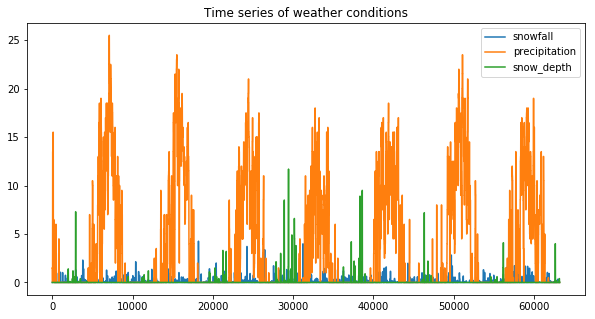

In [117]:
plt.subplots(figsize=(10, 5))
plt.plot(df_plot[['snowfall']])
plt.plot(df_plot[['precipitation']])
plt.plot(df_plot[['snow_depth']])
plt.legend(('snowfall', 'precipitation', 'snow_depth'),
           loc='upper right')
plt.title('Time series of weather conditions')

In [125]:
df_plot['rides'][500:524]

500     86
501     58
502     52
503     47
504     16
505      5
506      1
507      4
508      1
509      1
510      1
511     17
512     34
513     29
514      4
515      9
516      3
517      2
518      1
519     10
520     18
521     35
522    106
523     96
Name: rides, dtype: int64

Text(0.5,1,'Time series of temperature conditions')

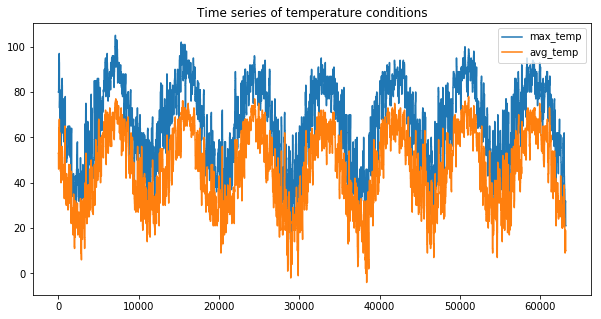

In [118]:
plt.subplots(figsize=(10, 5))
plt.plot(df_plot[['max_temp']])
plt.plot(df_plot[['avg_temp']])
plt.legend(('max_temp', 'avg_temp'),
           loc='upper right')
plt.title('Time series of temperature conditions')

Text(0.5,1,'Time series of rides vs temperature')

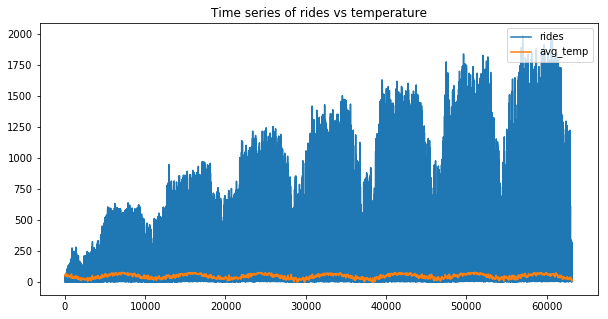

In [120]:
plt.subplots(figsize=(10, 5))
plt.plot(df_plot[['rides']])
plt.plot(df_plot[['avg_temp']])
plt.legend(('rides', 'avg_temp'),
           loc='upper right')
plt.title('Time series of rides vs temperature')

### Modelling

In [97]:
from pyspark.ml.linalg import DenseVector

# Fitting the data to a vector proper for the model
data = df_join.rdd.map(lambda row: (row[0], DenseVector(row[1:])))

In [98]:
# Replace df with the new DataFrame
df = spark.createDataFrame(data, ["label", "features"])

In [99]:
from pyspark.ml.feature import StandardScaler

# Defining scaler
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame to the scaler
scaler = standardScaler.fit(df)

# Transform the data in df using the scaler
scaled_df = scaler.transform(df)

# Inspect the result
scaled_df.take(2)

[Row(label=2, features=DenseVector([11.0, 80.0, 53.0, 0.0, 1.5, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]), features_scaled=DenseVector([1.5912, 4.4027, 3.0871, 0.0, 0.269, 0.0, 0.0, 2.0004, 0.0, 2.8619, 0.0, 0.0, 0.0, 0.0, 0.0])),
 Row(label=17, features=DenseVector([12.0, 80.0, 53.0, 0.0, 1.5, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]), features_scaled=DenseVector([1.7358, 4.4027, 3.0871, 0.0, 0.269, 0.0, 0.0, 2.0004, 0.0, 2.8619, 0.0, 0.0, 0.0, 0.0, 0.0]))]

In [100]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2],seed=1234)
print('Training records : %d' % train_data.count())
print('Test records : %d ' % test_data.count())

Training records : 50634
Test records : 12558 


In [101]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="label", maxIter=10, elasticNetParam=0.8)

# Fit the data to the models
linearModelA = lr.fit(train_data,{lr.regParam:0.1})
linearModelB = lr.fit(train_data,{lr.regParam:0.3})
linearModelC = lr.fit(train_data,{lr.regParam:0.6})

In [108]:
linearModelA.coefficients

DenseVector([15.7717, 5.1202, 0.7372, -102.5663, -7.3912, 4.0278, -12.4108, 52.696, -13.8801, -18.5376, 4.2007, 6.2212, 5.8688, 0.0, 3.6601])

In [103]:
# Generate predictions for models
predictedA = linearModelA.transform(test_data)
predictedB = linearModelB.transform(test_data)
predictedC = linearModelC.transform(test_data)

In [109]:
predictedB.toPandas().head(10)

,label,features,features_scaled,prediction
0,1,"[0.0, 61.0, 40.0, 0.0001, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 3.35702944413, 2.32988619079, 0.00031814...",105.624205
1,1,"[0.0, 81.0, 62.0, 0.39, 6.5, 0.0, 0.0, 1.0, 0....","[0.0, 4.45769483564, 3.61132359572, 1.24074771...",188.233206
2,1,"[0.0, 94.0, 63.0, 0.0, 13.5, 0.0, 0.0, 1.0, 0....","[0.0, 5.17312734013, 3.66957075049, 0.0, 2.420...",248.168735
3,1,"[4.0, 67.0, 47.0, 0.29, 0.0, 0.0, 1.0, 0.0, 1....","[0.57860068115, 3.68722906158, 2.73761627418, ...",148.067008
4,2,"[0.0, 73.0, 58.0, 0.01, 0.5, 0.0, 0.0, 0.0, 0....","[0.0, 4.01742867904, 3.37833497664, 0.03181404...",177.673223
5,2,"[0.0, 80.0, 46.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","[0.0, 4.40266156607, 2.67936911941, 0.0, 0.0, ...",258.817017
6,2,"[3.0, 73.0, 58.0, 0.01, 0.5, 0.0, 0.0, 0.0, 0....","[0.433950510863, 4.01742867904, 3.37833497664,...",224.968258
7,2,"[6.0, 73.0, 59.0, 0.05, 1.0, 0.0, 1.0, 1.0, 1....","[0.867901021725, 4.01742867904, 3.43658213141,...",288.514300
8,3,"[0.0, 66.0, 52.0, 0.3, 0.0, 0.0, 0.0, 1.0, 0.0...","[0.0, 3.63219579201, 3.02885204802, 0.95442131...",166.890285
9,3,"[6.0, 73.0, 58.0, 0.01, 0.5, 0.0, 0.0, 0.0, 0....","[0.867901021725, 4.01742867904, 3.37833497664,...",272.263293


In [106]:
# Get the RMSE 
print('RMSE for model A is: %f' % linearModelA.summary.rootMeanSquaredError)
print('RMSE for model B is: %f' % linearModelB.summary.rootMeanSquaredError)
print('RMSE for model C is: %f' % linearModelC.summary.rootMeanSquaredError)

RMSE for model A is: 283.336467
RMSE for model B is: 283.337654
RMSE for model C is: 283.377497


In [107]:
# Get the R2
print('R squared for model A is: %f' % linearModelA.summary.r2)
print('R squared for model B is: %f' % linearModelB.summary.r2)
print('R squared for model C is: %f' % linearModelC.summary.r2)

R squared for model A is: 0.217682
R squared for model B is: 0.217676
R squared for model C is: 0.217456
